In [11]:
# imports
import pandas as pd
import seaborn as sns
import numpy as np


In [2]:
df = pd.read_csv('insurance.csv')
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.describe().style.format("{0:.2f}").set_caption("Dataset numerical features description")


,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


In [5]:
def data_info(df):
    data = {
        'Column Name': df.columns,
        'Data Type': [str(df[col].dtype) for col in df.columns],
        'Non-Null Count': df.count().values
    }

    info_df = pd.DataFrame(data)

    info_df.style.set_caption('Dataset information')
    
    return info_df

data_info(df)

,Column Name,Data Type,Non-Null Count
0,age,int64,1338
1,sex,object,1338
2,bmi,float64,1338
3,children,int64,1338
4,smoker,object,1338
5,region,object,1338
6,charges,float64,1338


We have no missing values which is good. We have 3 columns with categorical values. We will convert them to numerical values using one hot encoding. We will also scale the numerical values using StandardScaler. We will then use a simple linear regression model to predict the price of the hospital charges.

children: Number of children covered by health insurance / Number of dependents

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

charges: Individual medical costs billed by health insurance

### Question 3.
Let’s begin with some visualisations.

• Based on your intuition what are the most important variables for predicting your target variable?

• Create visualisations that take into account the type of variable (categorical, numerical) that show
the correlation of the features you selected.

• Don’t forget to clean your dataset as needed in order to deal with missing values and outliers


In [21]:
import plotly.express as px


fig = px.histogram(df, x='charges', marginal="violin",
                   title='Charges Distribution',
                   labels={'charges': 'Charges'},
                   nbins= 100) 

fig.update_layout(title_text='Charges Distribution', title_x=0.5,
                  title_font=dict(size=18),
                  bargap=0.05)
# Show plot
fig.show()


The KDE (Kernel Density Estimate) is represented by the line tracing the top of the distribution, providing an estimation of the probability density function of the variable.

In [15]:
fig = px.box(df, y='charges', title='Charges Distribution')
# Show plot
fig.show()

Since the distribution of the charges is not normal, we will use the Spearman correlation coefficient to measure the strength and direction of the relationship between the charges and the other variables.

<Axes: >

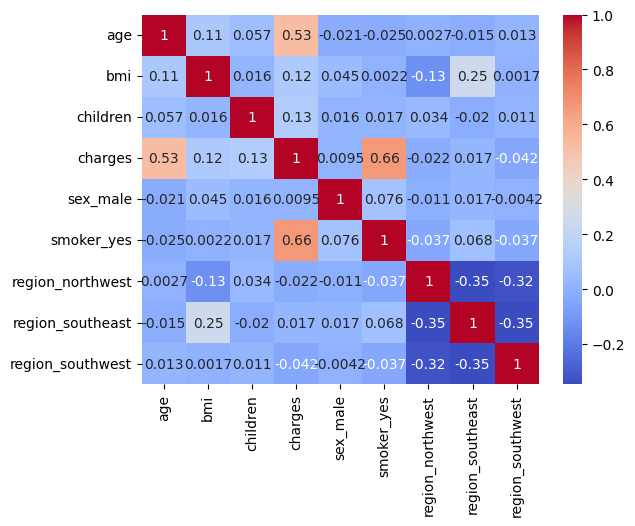

In [63]:
#spearman correlation
corr = df.corr(method='spearman')
#plotting the correlation
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True)


In [28]:
#age distribution
fig = px.histogram(df, x='bmi',
                   title='BMI Distribution',
                   labels={'bmi': 'BMI'},
                   nbins= 100)
fig.show()

In [31]:
#age distribution curve
fig = px.histogram(df, x='age',
                   title='Age Distribution',
                   labels={'age': 'Age'},
                   nbins= 100)
fig.show()


In [23]:
fig = px.scatter(df, x='age', y='charges', color='smoker', title='Charges vs Age')

fig.update_layout(title_text='Charges vs Age', title_x=0.5,
                    title_font=dict(size=18),
                    xaxis_title='Age',
                    yaxis_title='Charges')

Here we can see better than on the graph above the distribution of the charges. 

In [33]:
#gender  with pie chart
fig = px.pie(df, names ='sex', title= 'Distribution of sex in the data')
fig.show()

In [36]:
#region distribution by smoker 
fig = px.histogram(df, x='region', color='smoker', title='Region Distribution by Smoker', barmode='group')
fig.show()

In [43]:
import plotly.express as px

# Assuming `df` is your DataFrame

# Create a scatter plot matrix
fig = px.scatter_matrix(df,
                        dimensions=df.columns, # Replace with specific columns if needed
                        #color='green', # This sets the color of the points
                        title='Pairplot of the DataFrame')

# Update the layout and the marker appearance
fig.update_traces(diagonal_visible=False, # removes histograms on the diagonal
                  marker=dict(color='green', opacity=0.7, line=dict(color='#aec6cf', width=1)),
                  showupperhalf=False) # To mimic `corner=True`

fig.update_layout(
    title='Pairplot of the DataFrame',
    width=1000,  # Set the width of the plot
    height=1000  # Set the height of the plot
)

# Show plot
fig.show()


# drop region since its equaly reparted with charges (last graph) ? and not interseting ?

### Question 4.
Let’s do a linear regression.

• Do the variable transformations that are needed (on hot encoding, log etc...) 

• Fit the linear regression

• Interpret the coefficients of your regression

• Does any coefficient contradict your intuition?


# log on charges ?

In [44]:
#one hot encoding on the categorical columns
df = pd.get_dummies(df, columns=["sex", "smoker", "region"], drop_first=True)

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['bmi'] = scaler.fit_transform(df[['bmi']])
df['age'] = scaler.fit_transform(df[['age']])
df

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453320,0,16884.92400,False,True,False,False,True
1,-1.509965,0.509621,1,1725.55230,True,False,False,True,False
2,-0.797954,0.383307,3,4449.46200,True,False,False,True,False
3,-0.441948,-1.305531,0,21984.47061,True,False,True,False,False
4,-0.513149,-0.292556,0,3866.85520,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...
1333,0.768473,0.050297,3,10600.54830,True,False,True,False,False
1334,-1.509965,0.206139,0,2205.98080,False,False,False,False,False
1335,-1.509965,1.014878,0,1629.83350,False,False,False,True,False
1336,-1.296362,-0.797813,0,2007.94500,False,False,False,False,True


In [47]:
from sklearn.model_selection import train_test_split
y = df['charges']
X = df.drop("charges" , axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)


In [59]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train) 


#more  model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')



Mean Squared Error: 33596915.851361476
Mean Absolute Error: 4181.194473753653
R2 Score: 0.7835929767120722



### Question 5.
Let’s build a more complex model

• Build the ”best” model you can using traditional data science (no deep learning)

• Don’t hesitate to fine tune it, try different combination of variables etc

• What is the best metric you can reach? Can you consider it ”good”

• Given your results what use case can be done with this model?


Let's start by listing some models we can use: for this regression we can use linear regression, decision tree, random forest, gradient boosting, support vector machine, k-nearest neighbors etc.
Here the best model will be the one with the best R2 score. We will use cross validation to avoid overfitting. We will also use grid search to find the best hyperparameters for each model.
In this case the best model for this type of data would be random forest or gradient boosting.

In [60]:
#lets try random forest with a grid search
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 200, 300, 1000],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth': [10, 30, 50],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]}      

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=10)
grid_search.fit(X_train, y_train)

grid_search.best_params_



Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\Izard\anaconda3\envs\MACHINELEARNING\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
266 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Izard\anaconda3\envs\MACHINELEARNING\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Izard\anaconda3\envs\MACHINELEARNING\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\Izard\anaconda3\envs\MACHINELEARNING\lib\site-packages\sklearn\base.py", line 637, in _validate_param

{'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [61]:
#model evaluation
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')


Mean Squared Error: 20208955.650543094
Mean Absolute Error: 2658.2260589818825
R2 Score: 0.8698285296352715
